In [96]:
#numpy est une bibliothèque destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
import numpy as np
#open3d est une bibliothèque open-source qui prend en charge le développement rapide de logiciels traitant des données 3D.
import open3d as o3d
from numpy.linalg import eig
import plotly.express as px
import plotly.graph_objects as go 
import glob
import os
import trimesh

In [97]:
def visualize_mesh(path_obj):
    mesh = o3d.io.read_triangle_mesh(path_obj)
    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:,0],
                y=vertices[:,1],
                z=vertices[:,2],
                i=triangles[:,0],
                j=triangles[:,1],
                k=triangles[:,2],
                facecolor=colors,
                opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
def visualize_cloud(points):
    fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color='black')
        )
        ],
        layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
        )
        )
    fig.show()

def visualize_mesh_from_point_cloud(p):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(p)
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd,7)
    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:,0],
                y=vertices[:,1],
                z=vertices[:,2],
                i=triangles[:,0],
                j=triangles[:,1],
                k=triangles[:,2],
                facecolor=colors,
                opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [98]:
points = []
num_points= 2970
k=60

In [99]:
files = glob.glob(os.path.join("Input/Arcade/*"))
for f in files:
    points.append(trimesh.load(f).sample(num_points))  
        
points = np.asarray(points)
points.shape

unable to load materials from: ./simplify_11.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_12.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_13.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_14.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_15.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_16.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_17.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_18.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_19.obj.mtl
specified material (material_0)  not loaded!
unable to load materials from: ./simplify_20.obj.mtl
specified material (material_0)  not loaded!
unable to load mater

(11, 2970, 3)

In [101]:
visualize_cloud(points[0,:,:])

In [134]:
visualize_mesh("Input/Arcade/simplify_21.obj")

In [103]:
Smoy = np.zeros((num_points,3))
for i in range(11):
    Smoy += points[i,:,:]

Smoy = (1/11) * Smoy

In [104]:
print("moy shape",Smoy.shape)

moy shape (2970, 3)


In [105]:
#Calculant les vecteurs de deformation
Sdf = np.zeros((11,num_points,3))
for i in range(11):
    Sdf[i,:,:]= points[i,:,:] - Smoy

In [106]:
#Matrice de covariance 
C = np.zeros((num_points,num_points))
for i in range(11):
    C += Sdf[i,:,:] @ Sdf[i,:,:].T
C = (1/11)*C

In [107]:
print("dimension de matrice covariance ",C.shape)

dimension de matrice covariance  (2970, 2970)


In [108]:
eigen_vals, eigen_vecs = np.linalg.eigh(C)
print('E-value:', eigen_vals.shape)
print('E-vector', eigen_vecs.shape)

E-value: (2970,)
E-vector (2970, 2970)


Number of components explaining 0.95% variance: 20




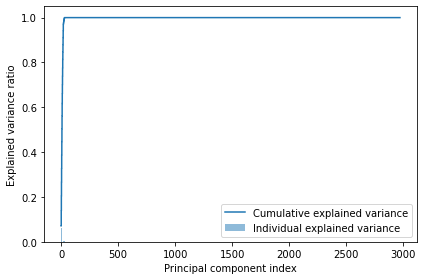

In [118]:
# Déterminer la variance expliquée
egnvalues = eigen_vals
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]
#
# Tracer la variance expliquée par rapport à la variance expliquée cumulative
#
import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
threshold = 0.95
k = np.argmax( cum_sum_exp > threshold) + 1
print(f"Number of components explaining {threshold}% variance: " + str(k))
print("\n")
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [116]:
# Get principal components[p1, p2, p3,...,pk]
sort = eigen_vals[::-1].argsort() 
eigen_vals[::-1].sort() 
eigen_vecs = eigen_vecs[:, sort]
eigenmesh =  np.column_stack((eigen_vecs[:,0:k]))
#size kx N
print("shape of eigen mesh",eigenmesh.shape) 

shape of eigen mesh (20, 2970)


In [117]:
weights = np.zeros((11,k,3))
for i in range(11):
    weights[i,:,:] =  eigenmesh @ (points[i,:,:] - points[0,:,:].mean())
print("shape of eigen mesh",weights.shape) 

shape of eigen mesh (11, 20, 3)


In [91]:
mu = weights.mean()
sigma = weights.std()

# def random_weights(mu, sigma, k):
#     # generate random weights with a normal distribution
#     return np.random.normal(mu, sigma, k)

# a = random_weights(mu,sigma,k)
# a

In [92]:
newscan = eigenmesh.T @ weights[9] + Smoy

In [93]:
import pandas as pd
from pyntcloud import PyntCloud
import numpy as np


def use_pyntcloud(pts, write_text):
    # ref: https://pyntcloud.readthedocs.io/en/latest/io.html
    # the doc is scarce and not complete

    n = len(pts)

    # The points must be written as a dataframe,
    # ref: https://stackoverflow.com/q/70304087/6064933
    data = {'x': pts[:, 0],
            'y': pts[:, 1],
            'z': pts[:, 2],
            'red': np.random.rand(n),
            'blue': np.random.rand(n),
            'green': np.random.rand(n)
            }

    # build a cloud
    cloud = PyntCloud(pd.DataFrame(data))

    # the argument for writing ply file can be found in
    # https://github.com/daavoo/pyntcloud/blob/7dcf5441c3b9cec5bbbfb0c71be32728d74666fe/pyntcloud/io/ply.py#L173
    name = 'file_'+write_text+'.ply'
    cloud.to_file(name, as_text=write_text)

    # read file
    cloud = PyntCloud.from_file(name)
    # print(cloud)

In [95]:
use_pyntcloud(newscan,"99")
use_pyntcloud(points[1,:,:],"hhhhhhhhh")

In [71]:
visualize_cloud(newscan)
print("========================================")
visualize_cloud(points[1,:,:])

In [20]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[1,:,:])
o3d.visualization.draw_geometries([pcd])  


In [21]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(newscan)
o3d.visualization.draw_geometries([pcd]) 

In [22]:
#Reconstructed data 
newdata = np.zeros((11,num_points,3))
for i in range(11):
    newdata[i,:,:] =  eigenmesh.T @ weights[i,:,:] + Smoy

In [23]:
print("=====================Originale===================")
visualize_mesh_from_point_cloud(newdata[1])
print("=====================Reconstructed===================")
visualize_mesh_from_point_cloud(points[1,:,:])

=====================Originale===================


=====================Reconstructed===================


In [33]:
visualize_mesh_from_point_cloud(newscan)

In [34]:
newscan = eigenmesh.T @ weights[1] + Smoy

In [35]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[1,:,:])
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd,3)
print("Computing normal and rendering it.")
mesh.compute_vertex_normals()
print(np.asarray(mesh.triangle_normals))
o3d.visualization.draw_geometries([mesh])

Computing normal and rendering it.
[[ 0.23982077 -0.81565291  0.52649438]
 [ 0.03391365 -0.66525926  0.74584179]
 [ 0.12508706 -0.87255444  0.47223085]
 ...
 [ 0.23022521  0.33804032  0.91253772]
 [-0.52600631  0.82163124  0.21963485]
 [-0.23084023 -0.33776617 -0.91248386]]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [474]:
obj=  newscan 
fig = px.scatter_3d(obj,obj[:, 0], obj[:, 1], obj[:, 2]) 
print("================Reconstructed 2=======================")
fig.show()
visualize_cloud(obj) 
fig.update_traces(mode='markers',marker=dict(size=1.8,color='grey',opacity=1,line=dict(width=0.01,color='DarkSlateGrey')))
fig.write_html("K20.html")

================Reconstructed 2=======================
